In [1]:
import fitsio
import proplot as pplt
import numpy as np
import glob
import tqdm
import sys

from mattspy.stats import mad

In [2]:
fnames = glob.glob("./results/meas*.fits")

d = []
for fname in tqdm.tqdm(fnames, ncols=79):
    d.append(fitsio.read(fname, ext="data"))
d = np.concatenate(d)

aps = fitsio.read(fname, ext="aps")

sys.stderr.flush()
sys.stdout.flush()
print("# of samples:", d.shape[0])

ap_ind = np.where(aps == 1.5)[0][0]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


# of samples: 264900


In [3]:
s2n_bins = np.linspace(5, 50, 15)

def _resample_stat(x, func, n=500, rng=None):
    if rng is None:
        rng = np.random.RandomState()
        
    vals = []
    for _ in range(n):
        vals.append(func(rng.choice(x, size=len(x), replace=True)))
    return func(x), np.std(vals)


def _resample_stat_two(x, w, func, n=500, rng=None):
    if rng is None:
        rng = np.random.RandomState()
        
    vals = []
    for _ in range(n):
        inds = rng.choice(len(x), size=len(x), replace=True)
        vals.append(func(x[inds], w[inds]))
    return func(x, w), np.std(vals)


def _fvar(x, xerr):
    ex = np.std(x)
    ex_err = np.sqrt(np.sum(xerr**2)/len(x))
    return ex/ex_err-1

nb = 100
chis = []
chi2s = []
out_5 = []
ms2n = []
ffluxes = []
ffluxes_ap = []

for i in range(len(s2n_bins)-1):
    min_s2n = s2n_bins[i]
    max_s2n = s2n_bins[i+1]
    
    msk = (
        (d["flux_flags"][:, ap_ind] == 0) 
        & (d["true_s2n"][:, ap_ind] > min_s2n)
        & (d["true_s2n"][:, ap_ind] < max_s2n)
    )
    ms2n.append(np.mean(d["s2n"][msk, ap_ind]))
    chi_num = (d["flux"][msk, ap_ind] - d["true_ap_flux"][msk, ap_ind])
    chi_den = d["flux_err"][msk, ap_ind]
    chi = chi_num/chi_den
    fflux = (d["true_ap_flux"][msk, ap_ind] - d["true_flux"][msk, ap_ind])/d["true_flux"][msk, ap_ind] + 1
    fflux_ap = (d["flux"][msk, ap_ind] - d["true_ap_flux"][msk, ap_ind])/d["true_ap_flux"][msk, ap_ind]
    chis.append(_resample_stat(chi, lambda x: np.mean(x), n=nb))
    chi2s.append(_resample_stat_two(chi_num, chi_den, _fvar, n=nb))
    out_5.append(_resample_stat(chi, lambda x: np.sum(np.abs(x) > 5)/np.sum(msk), n=nb))
    ffluxes.append(_resample_stat(fflux, np.mean, n=nb))
    ffluxes_ap.append(_resample_stat(fflux_ap, np.mean, n=nb))
    print(
        "%10.3f %10.3f %10.3f %10.3f %10.3f %10.3e %10.3e" % (
            min_s2n, max_s2n,
            np.sum(msk), 
            np.mean(chi),
            _fvar(chi_num, chi_den),
            np.sum(np.abs(chi) > 5)/np.sum(msk),
            np.mean(fflux)
        )
    )
    
chis = np.array(chis)
chi2s = np.array(chi2s)
out_5 = np.array(out_5)
ms2n = np.array(ms2n)
ffluxes = np.array(ffluxes)
ffluxes_ap = np.array(ffluxes_ap)

     5.000      8.214  42450.000      0.007     -0.004  0.000e+00  8.495e-01
     8.214     11.429  21828.000     -0.000      0.002  0.000e+00  8.302e-01
    11.429     14.643  13526.000      0.016      0.005  0.000e+00  8.172e-01
    14.643     17.857   9325.000     -0.011     -0.007  0.000e+00  8.061e-01
    17.857     21.071   7045.000      0.002     -0.002  0.000e+00  7.945e-01
    21.071     24.286   5309.000      0.001     -0.010  0.000e+00  7.802e-01
    24.286     27.500   4087.000      0.003      0.023  0.000e+00  7.710e-01
    27.500     30.714   3458.000      0.044     -0.012  0.000e+00  7.654e-01
    30.714     33.929   2678.000      0.038      0.020  0.000e+00  7.654e-01
    33.929     37.143   2363.000      0.015     -0.027  0.000e+00  7.526e-01
    37.143     40.357   1903.000     -0.016     -0.012  0.000e+00  7.453e-01
    40.357     43.571   1691.000     -0.029      0.010  0.000e+00  7.420e-01
    43.571     46.786   1477.000      0.035      0.024  0.000e+00  7.403e-01

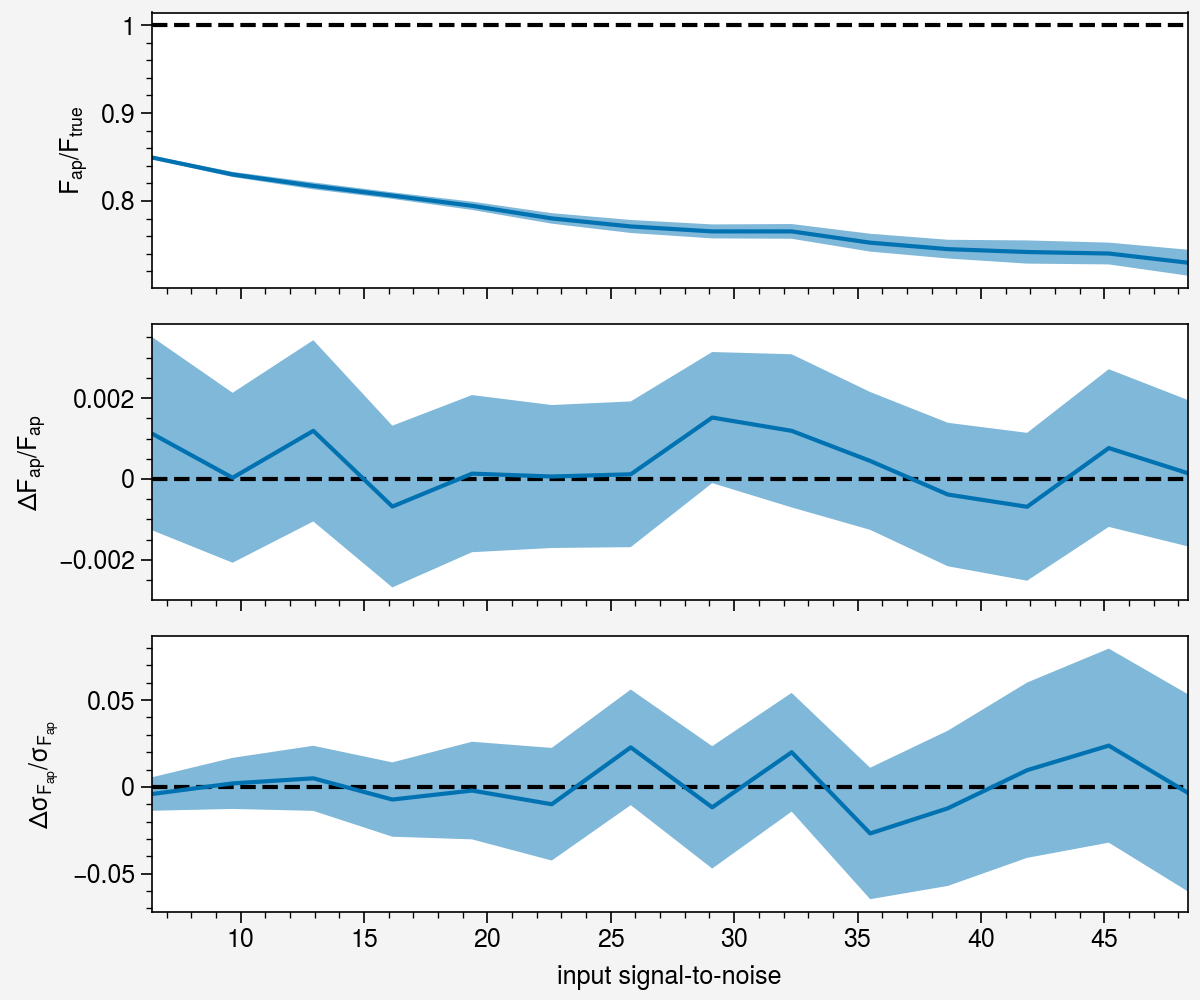

In [4]:
def _errplot(ax, x, ar):
    ax.plot(
        x,
        ar[:, 0],
    )
    ax.fill_between(
        x,
        ar[:, 0] - ar[:, 1]*3,
        ar[:, 0] + ar[:, 1]*3,
        alpha=0.5
    )
    ax.grid(False)


with pplt.rc.context(textusetex=False):
    fig, axs = pplt.subplots(nrows=3, ncols=1, sharex=3, sharey=0, figsize=(6, 5))

    axs[0, 0].axhline(1, color='k', linestyle="dashed")
    _errplot(axs[0, 0], ms2n, ffluxes)
    axs[0, 0].set_ylabel(r"$F_{\rm ap}/F_{\rm true}$")

    axs[1, 0].axhline(0, color='k', linestyle="dashed")
    _errplot(axs[1, 0], ms2n, ffluxes_ap)
    axs[1, 0].set_ylabel(r"$\Delta F_{\rm ap}/F_{\rm ap}$")

    axs[2, 0].axhline(0, color='k', linestyle="dashed")
    _errplot(axs[2, 0], ms2n, chi2s)
    axs[2, 0].set_xlabel("input signal-to-noise")
    axs[2, 0].set_ylabel(r"$\Delta \sigma_{F_{\rm ap}}/\sigma_{F_{\rm ap}}$")
    
    fig.savefig("test-noround-nodetect.pdf")